### Preparation

In [1]:
!pip install regex
!pip install ipinfo
!pip install geopandas
from pyspark.sql import SparkSession
import urllib.request
import regex
import matplotlib.pyplot as plt
import pandas as pd
import ipinfo
import geopandas

spark = SparkSession.builder.getOrCreate()
sc = spark.sparkContext

urllib.request.urlretrieve("http://raw.githubusercontent.com/elastic/examples/master/Common%20Data%20Formats/apache_logs/apache_logs","apache_logs")

lines = sc.textFile("apache_logs")

21/10/24 09:39:58 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
21/10/24 09:39:58 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


In [2]:
lines.first()

'83.149.9.216 - - [17/May/2015:10:05:03 +0000] "GET /presentations/logstash-monitorama-2013/images/kibana-search.png HTTP/1.1" 200 203023 "http://semicomplete.com/presentations/logstash-monitorama-2013/" "Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_1) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/32.0.1700.77 Safari/537.36"'

### Task 1

Narysować wykres rankingu najpopularniejszych stron źródłowych (referer), z wyłączeniem domeny semicomplete.com

In [3]:
domain_regex = r'(?:http|https)://([^/]+)/'

regex.search(domain_regex, '83.149.9.216 - - [17/May/2015:10:05:03 +0000] "GET /presentations/logstash-monitorama-2013/images/kibana-search.png HTTP/1.1" 200 203023 "http://semicomplete.com/presentations/logstash-monitorama-2013/" "Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_1) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/32.0.1700.77 Safari/537.36"').group(1)

'semicomplete.com'

In [4]:
def find_or_none(l):
    res = regex.search(domain_regex, l)
    if res == None:
        return None
    return res.group(1)

referer_ctr = lines.map(lambda l: find_or_none(l))\
    .filter(lambda l: l != None and regex.match(".*semicomplete.com",l) == None)\
    .map(lambda l: (l, 1))\
    .reduceByKey(lambda a, b: a + b)

In [5]:
most_popular_referers = referer_ctr.takeOrdered(10, lambda pair: -pair[1])
pd_referers = pd.DataFrame(most_popular_referers, columns=['Referer', 'Count'])

<AxesSubplot:ylabel='Referer'>

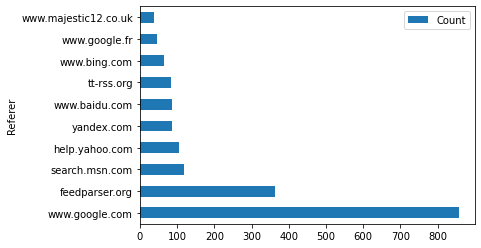

In [6]:
pd_referers.plot.barh(x = 'Referer')

### Task 2

Narysować wykres słupkowy liczby wywołań (request) na godzinę w zależności od czasu, pogrupowane po kodzie odpowiedzi (200, 404, etc)

In [7]:
hour_code_regex = r'\[[^:]+:(\d+)[^\]]+\]\s"[^"]+"\s(\d+)'

regex.search(hour_code_regex, '83.149.9.216 - - [17/May/2015:10:05:03 +0000] "GET /presentations/logstash-monitorama-2013/images/kibana-search.png HTTP/1.1" 200 203023 "http://semicomplete.com/presentations/logstash-monitorama-2013/" "Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_1) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/32.0.1700.77 Safari/537.36"').group(2)

'200'

In [8]:
def hour_code(l):
    res = regex.search(hour_code_regex, l)
    return int(res.group(1)), int(res.group(2))

hour_code_ctr = lines.map(lambda l: (hour_code(l),1))\
    .reduceByKey(lambda a, b: a + b)\
    .map(lambda l: (l[0][0], l[0][1], l[1]))

In [9]:
pd_hour_code = pd.DataFrame(hour_code_ctr.collect(), columns=['Hour', 'StatusCode', 'Count'])

<AxesSubplot:xlabel='Hour'>

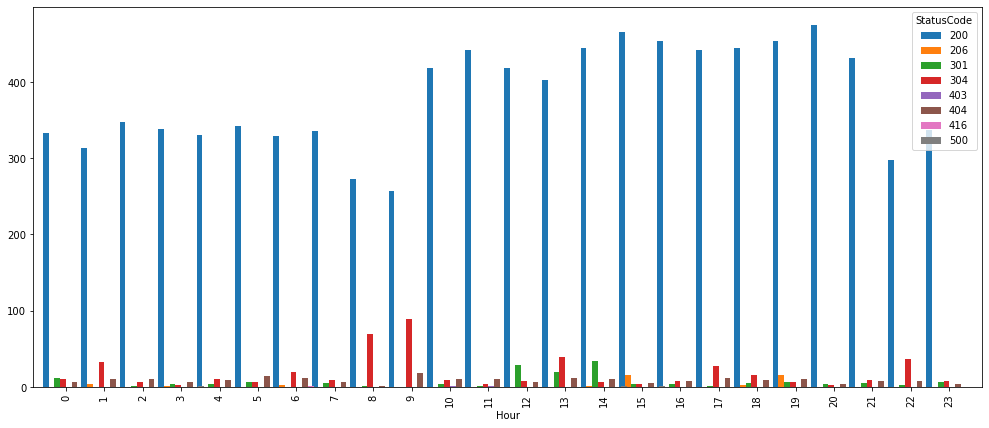

In [10]:
pd.pivot_table(pd_hour_code, values = 'Count', index = 'Hour',
               columns = 'StatusCode', aggfunc ='sum').plot.bar(figsize=(17,7),width=1.2)

### Task 3

Narysować wykres rankingu pobieranych zasobów według typów plików (html, css, png, etc.)

In [11]:
resource_type_regex = r'\[[^\]]+\]\s"[^\s]+\s[^\s]+\.([\w]+)\b'

regex.search(resource_type_regex, '83.149.9.216 - - [17/May/2015:10:05:03 +0000] "GET /presentations/logstash-monitorama-2013/images/kibana-search.png HTTP/1.1" 200 203023 "http://semicomplete.com/presentations/logstash-monitorama-2013/" "Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_1) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/32.0.1700.77 Safari/537.36"').group(1)

'png'

In [12]:
def find_or_none(l):
    res = regex.search(resource_type_regex, l)
    if res == None:
        return None
    return res.group(1)


resource_type_ctr = lines.map(lambda l: (find_or_none(l),1))\
    .reduceByKey(lambda a, b: a + b)\
    .sortBy(lambda x: x[1])

In [13]:
pd_resource_type = pd.DataFrame(resource_type_ctr.collect(), columns=['Type', 'Count'])

<AxesSubplot:ylabel='Type'>

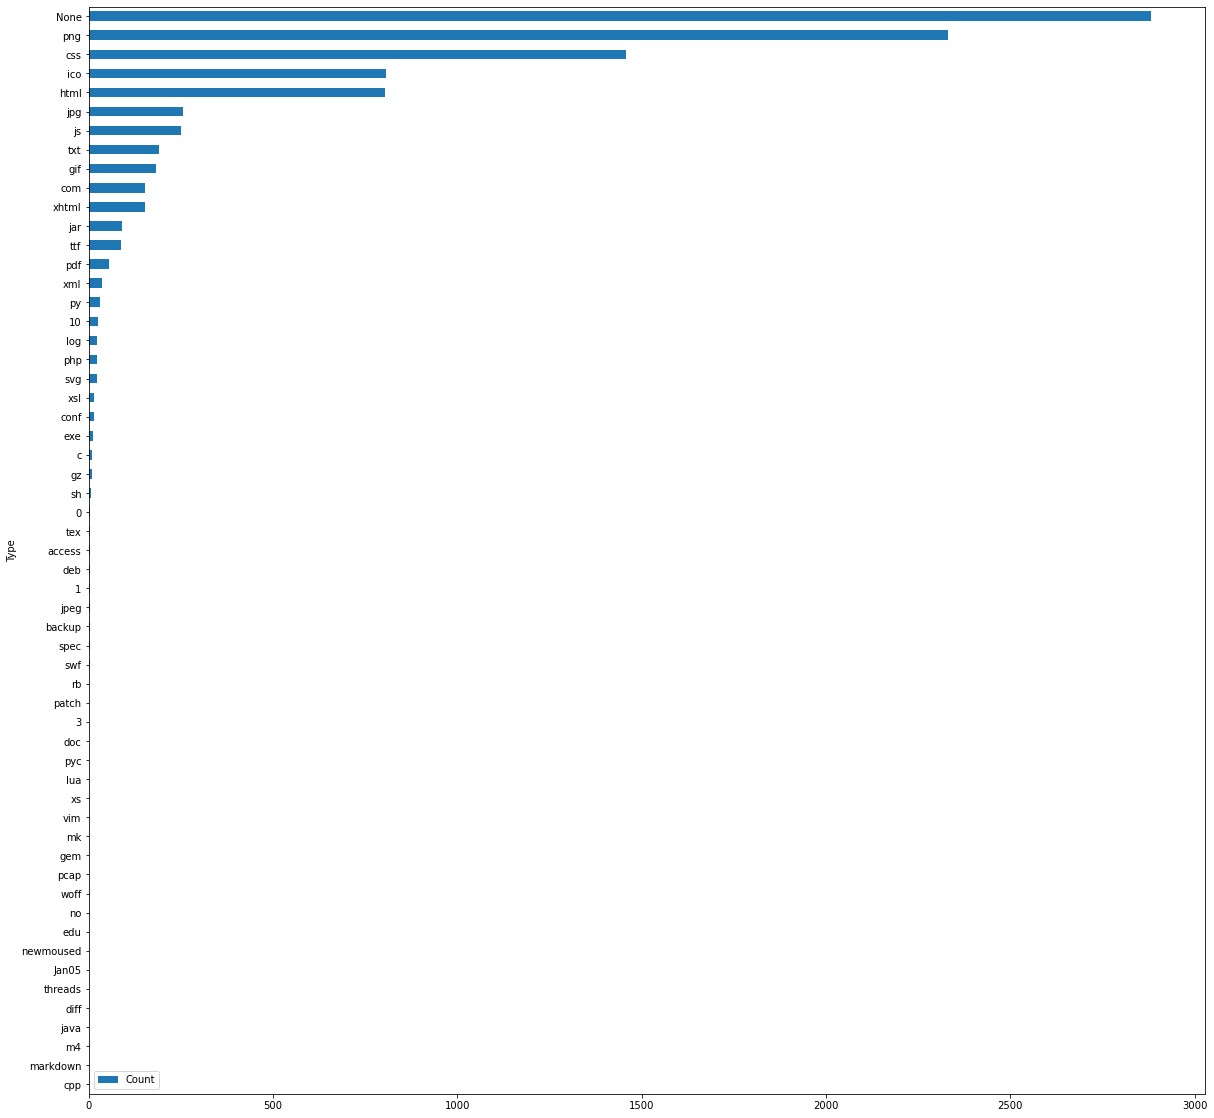

In [14]:
pd_resource_type.plot.barh(x = 'Type', figsize=(20,20))

### Task 4

Narysować mapę z lokalizacjami klientów

In [15]:
at = 'e09c398f834027'
handler = ipinfo.getHandler(at)
ip_address = '216.239.36.21'
details = handler.getDetails(ip_address)

In [16]:
details.loc

'37.4056,-122.0775'

In [17]:
ip_regex = '([(\d\.)]+)'
regex.search(ip_regex, '83.149.9.216 - - [17/May/2015:10:05:03 +0000] "GET /presentations/logstash-monitorama-2013/images/kibana-search.png HTTP/1.1" 200 203023 "http://semicomplete.com/presentations/logstash-monitorama-2013/" "Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_1) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/32.0.1700.77 Safari/537.36"').group(1)

'83.149.9.216'

In [18]:
ips_ctr = lines.map(lambda s: (regex.match(ip_regex, s).group(0) ,1))\
    .reduceByKey(lambda a, b: a + b)\
    .collect()

In [19]:
pd_ip = pd.DataFrame(ips_ctr, columns=['IP', 'Count'])
ips = pd_ip['IP'].to_numpy()

In [20]:
geolocation_data = handler.getBatchDetails(ips)

In [21]:
pd_ip['Location']=pd_ip['IP'].apply(lambda ip: geolocation_data[ip]['loc'])
pd_ip['Latitude']=pd_ip['Location'].apply(lambda loc: loc.split(',')[0])
pd_ip['Longitude']=pd_ip['Location'].apply(lambda loc: loc.split(',')[1])
pd_ip

,IP,Count,Location,Latitude,Longitude
0,83.149.9.216,23,"55.7522,37.6156",55.7522,37.6156
1,110.136.166.128,6,"-6.9931,110.4208",-6.9931,110.4208
2,46.105.14.53,364,"49.2061,7.9753",49.2061,7.9753
3,123.125.71.35,1,"39.9075,116.3972",39.9075,116.3972
4,200.49.190.100,1,"14.6407,-90.5133",14.6407,-90.5133
...,...,...,...,...,...
1748,176.31.39.30,2,"50.6942,3.1746",50.6942,3.1746
1749,92.115.179.247,6,"47.0056,28.8575",47.0056,28.8575
1750,66.169.220.99,1,"32.7714,-97.2915",32.7714,-97.2915
1751,91.151.182.109,6,"59.9386,30.3141",59.9386,30.3141


In [22]:
gpd_ip = geopandas.GeoDataFrame(pd_ip, geometry=geopandas.points_from_xy(pd_ip.Longitude, pd_ip.Latitude))
gpd_ip

,IP,Count,Location,Latitude,Longitude,geometry
0,83.149.9.216,23,"55.7522,37.6156",55.7522,37.6156,POINT (37.61560 55.75220)
1,110.136.166.128,6,"-6.9931,110.4208",-6.9931,110.4208,POINT (110.42080 -6.99310)
2,46.105.14.53,364,"49.2061,7.9753",49.2061,7.9753,POINT (7.97530 49.20610)
3,123.125.71.35,1,"39.9075,116.3972",39.9075,116.3972,POINT (116.39720 39.90750)
4,200.49.190.100,1,"14.6407,-90.5133",14.6407,-90.5133,POINT (-90.51330 14.64070)
...,...,...,...,...,...,...
1748,176.31.39.30,2,"50.6942,3.1746",50.6942,3.1746,POINT (3.17460 50.69420)
1749,92.115.179.247,6,"47.0056,28.8575",47.0056,28.8575,POINT (28.85750 47.00560)
1750,66.169.220.99,1,"32.7714,-97.2915",32.7714,-97.2915,POINT (-97.29150 32.77140)
1751,91.151.182.109,6,"59.9386,30.3141",59.9386,30.3141,POINT (30.31410 59.93860)


<AxesSubplot:>

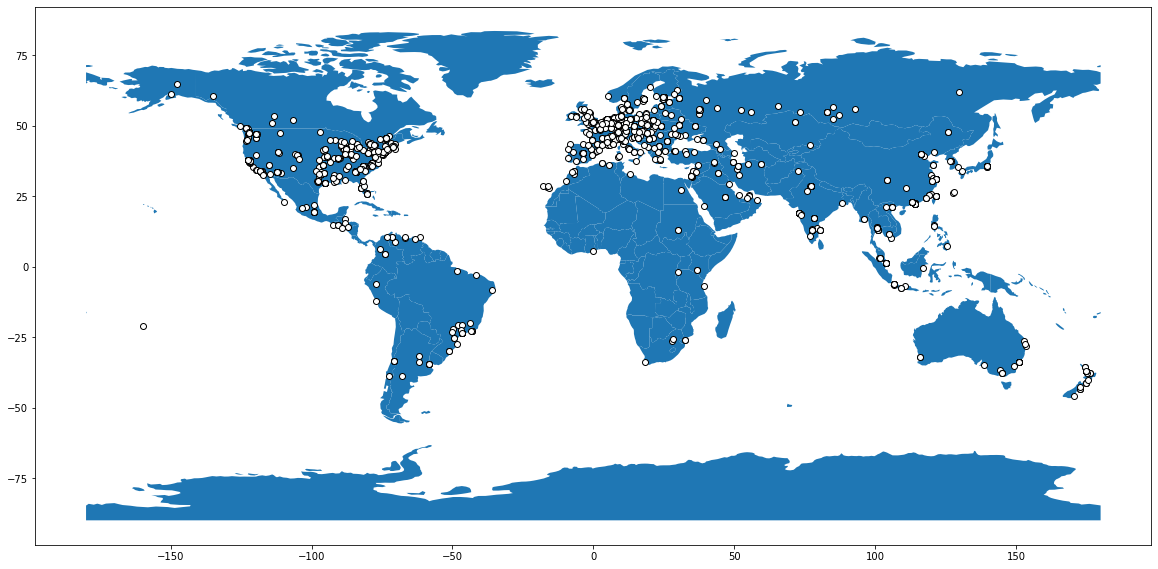

In [23]:
world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))
ax = world.plot(figsize=(20,10))
gpd_ip.plot(ax=ax, color='white', edgecolor='black')

### Task 5
Oszacować jaki procent ruchu generują boty

In [24]:
bot_regex = 'bot|spider'
regex.search(bot_regex, '83.149.9.216 - - [17/May/2015:10:05:03 +0000] "GET /presentations/logstash-monitorama-2013/images/kibana-search.png HTTP/1.1" 200 203023 "http://semicomplete.com/presentations/logstash-monitorama-2013/" "Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_1) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/32.0.1700.77 Safari/537.36"', regex.IGNORECASE)!= None

False

In [25]:
bot_ctr = lines.map(lambda s: ('Bot' if regex.search(bot_regex, s) != None else 'Non-Bot',1))\
    .reduceByKey(lambda x,y:x+y)\
    .collect()

In [26]:
bot = bot_ctr[0] if bot_ctr[0]=='Bot' else bot_ctr[1]
print(f'Percentage of bots traffic: {bot[1]/(bot_ctr[1][1]+bot_ctr[0][1])*100}%')

Percentage of bots traffic: 14.13%
